In [1]:
!pip install medmnist
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=8af849832f4f554de72c6b25233b27fff28fa2c8bfcc3ed5e27eb2d7d83104d8
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd
import medmnist
from medmnist import INFO
from collections import Counter
import time
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import seaborn as sns
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

In [3]:
# pip install imbalanced-learn

## Step 1: loading and preparing the dataset

In [4]:
#using the data loading reference from the getting started part of MedMnist
info = INFO['octmnist']
dataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation of the image
    transforms.RandomHorizontalFlip(),  # Flip image
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize range of [0,1]
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize range of [0,1]
])

train_dataset = dataClass(split='train',download=True,transform=transform)
val_dataset = dataClass(split='val', download=True, transform=transform_val_test)
test_dataset = dataClass(split='test', download=True,transform=transform_val_test)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")



100%|██████████| 54.9M/54.9M [00:03<00:00, 15.7MB/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Training set size: 97477
Validation set size: 10832
Test set size: 1000


In [5]:
# #handling class imbalance using smote similar to ML Assignment 2 part 1 and 2
train_images = []
train_labels = []

for img, label in train_dataset:
  train_images.append(img.numpy().flatten())  # flattening since images are 2d
  train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# print(train_labels[:10])  # Show first 10 labels


smote = SMOTE(sampling_strategy='auto',random_state=42)
train_images_new, train_labels_new = smote.fit_resample(train_images, train_labels)

train_images_new = train_images_new.reshape(-1, 1, 28, 28)  # Reshape

train_images_new = torch.tensor(train_images_new, dtype=torch.float32)
train_labels_new = torch.tensor(train_labels_new, dtype=torch.long)

# print(train_labels_new[:10])  # Show first 10 labels

print(f"New dataset sample size: {len(train_labels_new)}")


New dataset sample size: 184104


In [6]:

#Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(train_images_new, train_labels_new)

# train_dataset_new = TensorDataset(train_images_new, train_labels_new)

#Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the DataLoader sizes
print(f"Training batch: {len(train_loader)}")
print(f"Validation batch: {len(val_loader)}")
print(f"Test batch: {len(test_loader)}")


Training batch: 5754
Validation batch: 339
Test batch: 32


In [7]:
# for inputs, labels in train_loader:
#     print(f"Batch size of inputs: {inputs.size(0)}")
#     print(f"Batch size of labels: {labels.size(0)}")

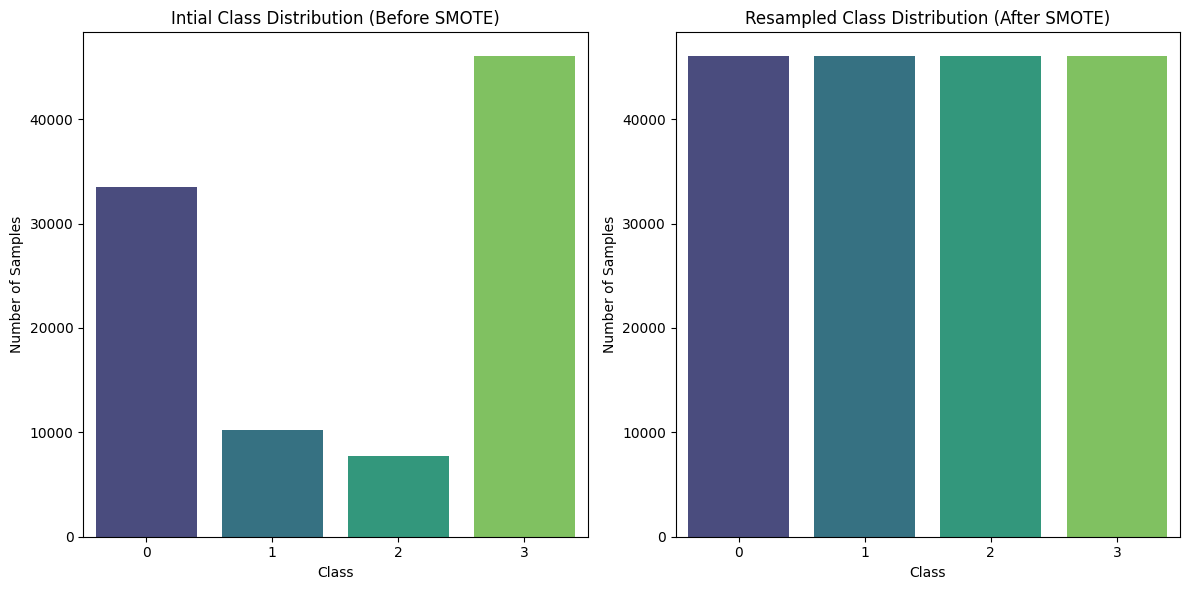

In [8]:
#before SMOTE
intial_classes, intial_counts = np.unique(train_labels, return_counts=True)

#after SMOTE
resampled_classes, resampled_counts = np.unique(train_labels_new, return_counts=True)

plt.figure(figsize=(12, 6))

#intial class distribution
plt.subplot(1, 2, 1)
sns.barplot(x=intial_classes, y=intial_counts, palette="viridis")
plt.title('Intial Class Distribution (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
sns.barplot(x=resampled_classes, y=resampled_counts, palette="viridis")
plt.title('Resampled Class Distribution (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.show()


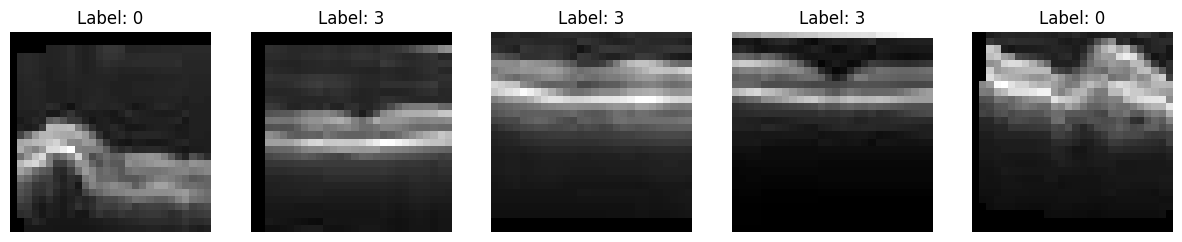

In [9]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
  img, label = train_dataset[i]
  ax = axes[i]
  img = img.reshape(28, 28)
  ax.imshow(img, cmap='gray')
  ax.set_title(f"Label: {label.item()}")
  ax.axis('off')

plt.show()


In [10]:
# #stastics of the data: ra65_ganeshdi_assignment 2: CNN's

#flattening to 1d
train_images = np.array([img.numpy().flatten() for img, _ in train_dataset])
train_labels = np.array([label.item() for _, label in train_dataset])

samples_train = len(train_labels)

image_height, image_width = 28, 28  #data.shape[1], data.shape[2]
num_classes = len(np.unique(train_labels))

train_class_distribution = pd.Series(train_labels).value_counts().sort_index()

#statistics of training set
pixel_mean_train = np.mean(train_images)
pixel_std_train = np.std(train_images)
pixel_min_train = np.min(train_images)
pixel_max_train = np.max(train_images)

print(f"Training Data Statistics:")
print(f"Number of Samples: {samples_train}")
print(f"Image Dimensions: {image_height} x {image_width}")
print(f"Number of Classes: {num_classes}")
print(f"\nClass Distribution in Training Set:\n{train_class_distribution}")
print(f"\nPixel Statistics (Training Set):")
print(f"Mean Pixel Value: {pixel_mean_train:.4f}")
print(f"Standard Deviation: {pixel_std_train:.4f}")
print(f"Min Pixel Value: {pixel_min_train}")
print(f"Max Pixel Value: {pixel_max_train}")



Training Data Statistics:
Number of Samples: 184104
Image Dimensions: 28 x 28
Number of Classes: 4

Class Distribution in Training Set:
0    46026
1    46026
2    46026
3    46026
Name: count, dtype: int64

Pixel Statistics (Training Set):
Mean Pixel Value: -0.6716
Standard Deviation: 0.3601
Min Pixel Value: -1.0
Max Pixel Value: 1.0


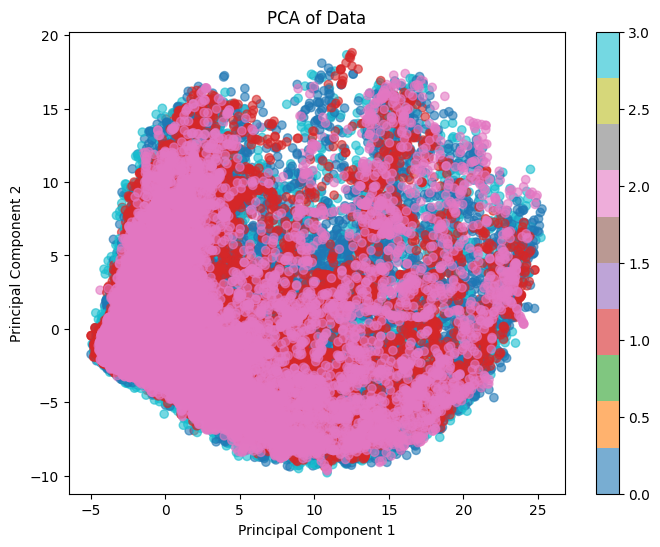

In [11]:
# referenced CSE574: ra65_ganeshdi_assignment 2: CNN's

from sklearn.decomposition import PCA

flat_data = train_images.reshape(train_images.shape[0], -1)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(flat_data)
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=train_labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("PCA of Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Step 2: Define Neural Network

In [12]:
#intialize arrays to stores loss values and collect accuracies
train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []
# avg_validation_accuracy = 0
# all_train_labels = []         #total_training_labels = []
# all_train_predictions = []          #total_training_predictions = []
# all_val_labels = []          #total_validation_labels = []
# all_val_predictions = []  #total_validation_predictions = []

# training_epoch_accuracy = 0
# validation_epoch_accuracy = 0

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True


In [13]:
n_channels = info['n_channels']
n_classes = len(info['label'])

print("number of input channls:", n_channels)
print("Classes: ", n_classes)


number of input channls: 1
Classes:  4


In [14]:
class CNNmodel_octmnist(nn.Module):
  def __init__(self):
    super(CNNmodel_octmnist, self).__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    # self.bn1 = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    # self.bn2 = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    # self.bn3 = nn.BatchNorm2d(256)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(256 * 3 * 3, 512)  # 3 conv layers and 2 max-pool
    self.fc2 = nn.Linear(512, 4)  # 4 classes

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):

    # x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
    # x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
    # x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))

    x = self.pool(nn.ReLU()(self.conv1(x)))
    x = self.pool(nn.ReLU()(self.conv2(x)))
    x = self.pool(nn.ReLU()(self.conv3(x)))

    x = x.view(-1, 256 * 3 * 3)

    x = nn.ReLU()(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

    # return F.softmax(x, dim=1)

model = CNNmodel_octmnist().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
CNNmodel_octmnist                        --
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            295,168
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            1,180,160
├─Linear: 1-8                            2,052
├─Dropout: 1-9                           --
Total params: 1,551,876
Trainable params: 1,551,876
Non-trainable params: 0

In [15]:
#referenced CSE574: ra65_ganeshdi_assignment 2: CNN's
#loss function
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)   #torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

start_time = time.time()

epochs = 10

# best_validation_loss = 0.0
# best_validation_accuracy = 0.0

save_path = "base_model_best_weights.pt"
best_validation_loss = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

for epoch in range(epochs):
  model.train()
  loop_train_loss = 0
  correct_train_length = 0
  total_train = 0

  for inputs, labels in train_loader:
      
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    
        
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    total_train += labels.size(0)
    correct_train_length += (predicted == labels).sum().item()

    loop_train_loss += loss.item()

  #training accuracy and loss
  train_accuracy_value = 100 * correct_train_length / total_train
  train_loss.append(loop_train_loss / len(train_loader))
  train_accuracy.append(train_accuracy_value)

  #Validation
  model.eval()
  loop_val_loss = 0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)

        # if val_labels.ndimension() > 1:  # In case labels are one-hot encoded
        #     val_labels = torch.argmax(val_labels, dim=1)

        val_labels = val_labels.view(-1)
        val_loss = loss_function(val_outputs, val_labels)

        # Track validation accuracy
        _, predicted = torch.max(val_outputs, 1)
        
        total_val += val_labels.size(0)
        correct_val += (predicted == val_labels).sum().item()
    
        loop_val_loss += val_loss.item()

  #validation accuracy and loss
  val_accuracy = 100 * correct_val / total_val
  validation_loss.append(loop_val_loss / len(val_loader))
  validation_accuracy.append(val_accuracy)

  print(f"Epoch [{epoch+1}/{epochs}], "
    f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%, "
    f"Val Loss: {validation_loss[-1]:.4f}, Val Accuracy: {validation_accuracy[-1]:.2f}%")

  # Save model with best validation accuracy
  if loop_val_loss < best_validation_loss:
    best_validation_loss = loop_val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()
    # torch.save(model.state_dict(), 'best_model.pth')  #Save the model weights


if best_model_weight is not None:
    torch.save(best_model_weight, save_path)
    print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time = time.time()
training_time = end_time - start_time  #total training time
print(f"Total Training Time: {training_time:.2f} seconds")

Epoch [1/10], Train Loss: 0.9034, Train Accuracy: 61.13%, Val Loss: 0.7482, Val Accuracy: 68.51%
Epoch [2/10], Train Loss: 0.6852, Train Accuracy: 73.28%, Val Loss: 0.6190, Val Accuracy: 75.56%
Epoch [3/10], Train Loss: 0.6434, Train Accuracy: 75.03%, Val Loss: 0.5616, Val Accuracy: 78.31%
Epoch [4/10], Train Loss: 0.6148, Train Accuracy: 76.10%, Val Loss: 0.5071, Val Accuracy: 80.39%
Epoch [5/10], Train Loss: 0.5925, Train Accuracy: 77.09%, Val Loss: 0.6100, Val Accuracy: 75.40%
Epoch [6/10], Train Loss: 0.5732, Train Accuracy: 77.85%, Val Loss: 0.5523, Val Accuracy: 78.13%
Epoch [7/10], Train Loss: 0.5586, Train Accuracy: 78.48%, Val Loss: 0.5922, Val Accuracy: 76.14%
Epoch [8/10], Train Loss: 0.5438, Train Accuracy: 79.01%, Val Loss: 0.5197, Val Accuracy: 79.99%
Epoch [9/10], Train Loss: 0.5348, Train Accuracy: 79.38%, Val Loss: 0.5839, Val Accuracy: 76.81%
Epoch [10/10], Train Loss: 0.5227, Train Accuracy: 79.75%, Val Loss: 0.5233, Val Accuracy: 79.42%
Best model weights saved to b

In [16]:
# # Load the best model
# model.load_state_dict(torch.load('best_model.pth'))

# Test phase
model.eval()
correct_test_length = 0
total_test = 0
y_true = []
y_pred = []

# test_loss = []
test_accuracy =[]
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
predicted_list = []


with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
      
    outputs = model(inputs)
    # print(f"Test outputs shape: {outputs.shape}")

    # if labels.ndimension() > 1:  # if labels are one-hot encoded
    #     labels = torch.argmax(labels, dim=1)

    labels = labels.view(-1)
    test_total_loss += loss_function(outputs, labels).item()
      
    _, predicted = torch.max(outputs, 1)
    predicted_test_probs = torch.softmax(outputs, dim=1)
      
    total_test += labels.size(0)
    correct_test_length += (predicted == labels).sum().item()

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
    predicted_list.extend(predicted_test_probs.cpu().numpy())


y_pred = np.array(y_pred)
y_true = np.array(y_true)
predicted_list = np.array(predicted_list)


print(f"Predicted: {y_pred[:10]}")  # Print the first 10 predicted values
print(f"Actual Labels: {y_true[:10]}")

test_accuracy = 100 * (correct_test_length / total_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")

#Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

test_loss = test_total_loss /len(test_loader)

test_accuracies_plot = [test_accuracy] * epochs
test_loss_plot = [test_loss] * epochs


Predicted: [3 2 3 3 0 2 1 0 0 3]
Actual Labels: [3 2 3 3 0 2 1 0 0 3]
Test Accuracy: 73.10%
Precision: 0.7301, Recall: 0.7310, F1: 0.7231


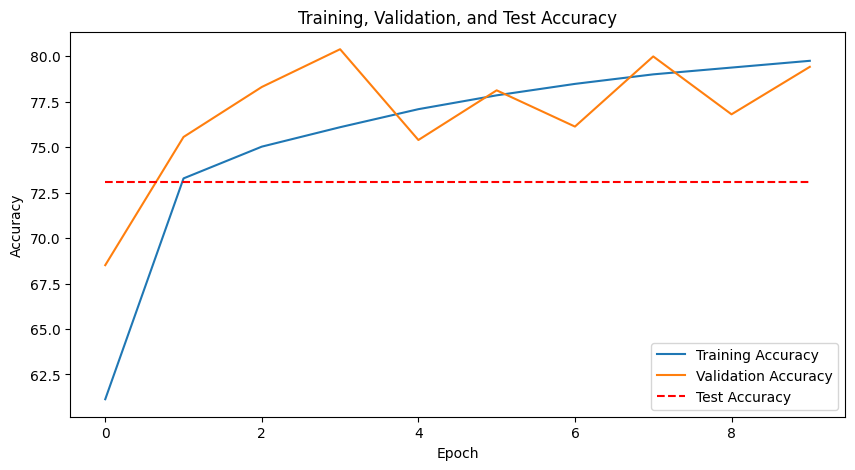

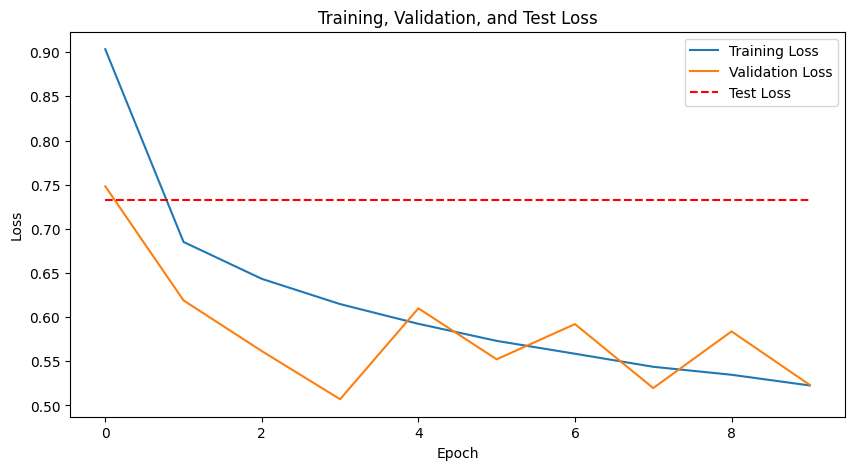

In [17]:
#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.plot(test_accuracies_plot, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.plot(test_loss_plot, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



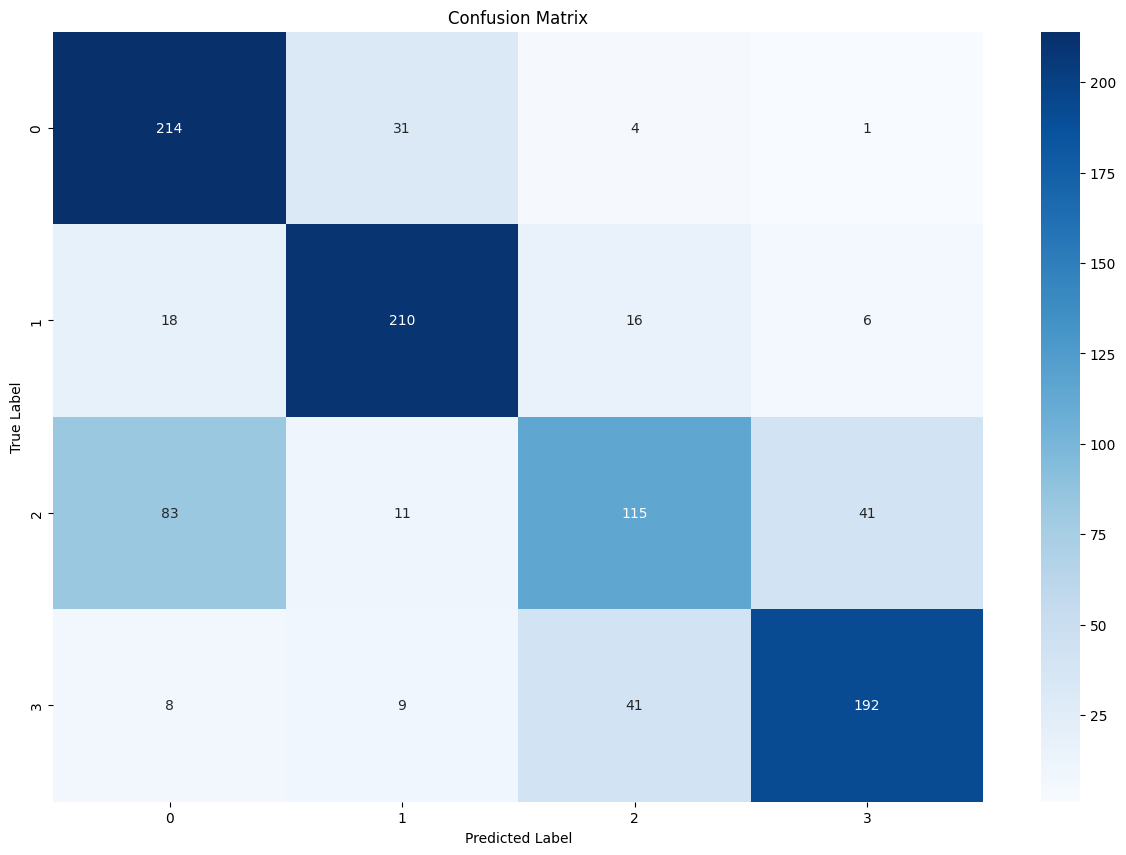

In [18]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

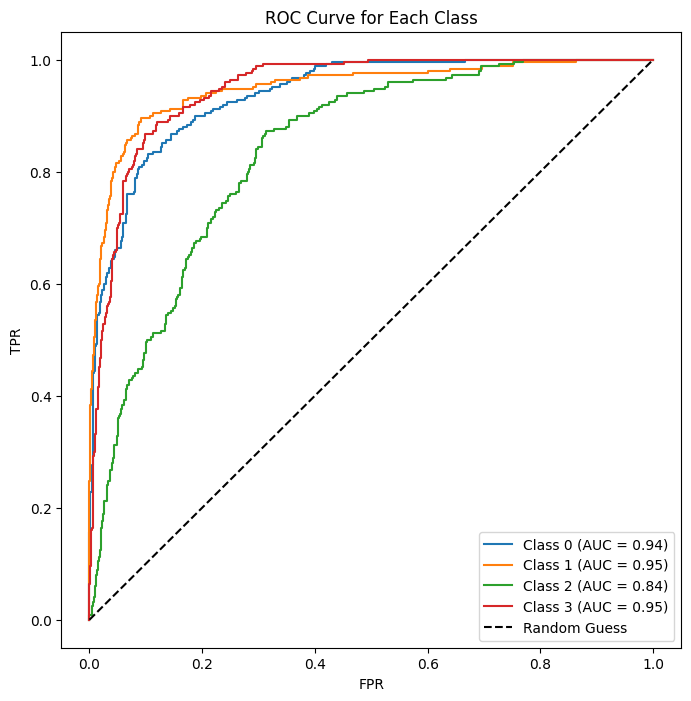

In [19]:
#plotting the ROC curve
plt.figure(figsize=(8,8))
test_dataset_labels_binarized = label_binarize(y_true, classes=np.arange(4))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_dataset_labels_binarized[:, i], predicted_list[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i}').plot(ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Each Class')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


# # Improvements to the Model - Changing hyperparameters

Hyperparameter changes #1: 

In [20]:
model_early_stopping = CNNmodel_octmnist().to(device)
loss_function_early_stopping = nn.CrossEntropyLoss()
optimizer_early_stopping = optim.Adam(model_early_stopping.parameters(), lr=0.001, weight_decay=0.00001)   #torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_loss_early_stopping = []
validation_loss_early_stopping = []
train_accuracy_early_stopping = []
validation_accuracy_early_stopping = []

start_time_early_stopping = time.time()

epochs = 10
counter = 0
patience_value = 4

# save_path = "best_weights.p"
best_validation_loss = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

for epoch in range(epochs):
  model_early_stopping.train()
  loop_train_loss = 0
  correct_train_length = 0
  total_train = 0

  for inputs, labels in train_loader:
      
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer_early_stopping.zero_grad()

    outputs = model_early_stopping(inputs)
    
    # if labels.ndimension() > 1:  # In case labels are one-hot encoded
    #     labels = torch.argmax(labels, dim=1)
        
    loss = loss_function_early_stopping(outputs, labels)
    loss.backward()
    optimizer_early_stopping.step()

    _, predicted = torch.max(outputs, 1)
    total_train += labels.size(0)
    correct_train_length += (predicted == labels).sum().item()

    loop_train_loss += loss.item()

  #training accuracy and loss
  train_accuracy_value_early_stopping = 100 * correct_train_length / total_train
  train_loss_early_stopping.append(loop_train_loss / len(train_loader))
  train_accuracy_early_stopping.append(train_accuracy_value_early_stopping)

  #Validation
  model_early_stopping.eval()
  loop_val_loss = 0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model_early_stopping(val_inputs)

        # if val_labels.ndimension() > 1:  # In case labels are one-hot encoded
        #     val_labels = torch.argmax(val_labels, dim=1)

        val_labels = val_labels.view(-1)
        val_loss = loss_function_early_stopping(val_outputs, val_labels)

        # Track validation accuracy
        _, predicted = torch.max(val_outputs, 1)
        
        total_val += val_labels.size(0)
        correct_val += (predicted == val_labels).sum().item()
    
        loop_val_loss += val_loss.item()

  #validation accuracy and loss
  val_accuracy_early_stopping = 100 * correct_val / total_val
  validation_loss_early_stopping.append(loop_val_loss / len(val_loader))
  validation_accuracy_early_stopping.append(val_accuracy_early_stopping)

  print(f"Epoch [{epoch+1}/{epochs}], "
    f"Train Loss: {train_loss_early_stopping[-1]:.4f}, Train Accuracy: {train_accuracy_early_stopping[-1]:.2f}%, "
    f"Val Loss: {validation_loss_early_stopping[-1]:.4f}, Val Accuracy: {validation_accuracy_early_stopping[-1]:.2f}%")


  if loop_val_loss < best_validation_loss:
    best_validation_loss = loop_val_loss
    best_epoch = epoch + 1
    best_model_weight = model_early_stopping.state_dict()
    counter = 0 
    # torch.save(model.state_dict(), 'best_model.pth')  #Save the model weights
  else:
      counter += 1

  if counter >= patience_value:
    print(f"Early stopping at epoch {epoch + 1} having validation loss: {validation_loss_early_stopping[-1]:.4f}")


# if best_model_weight is not None:
#     torch.save(best_model_weight, save_path)
#     print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time_early_stopping = time.time()
training_time_early_stopping = end_time_early_stopping - start_time_early_stopping  #total training time
print(f"Total Training Time for Early Stopping Model: {training_time_early_stopping:.2f} seconds")

Epoch [1/10], Train Loss: 0.8146, Train Accuracy: 66.73%, Val Loss: 0.6602, Val Accuracy: 74.03%
Epoch [2/10], Train Loss: 0.6199, Train Accuracy: 76.13%, Val Loss: 0.6303, Val Accuracy: 75.50%
Epoch [3/10], Train Loss: 0.5619, Train Accuracy: 78.51%, Val Loss: 0.4600, Val Accuracy: 82.85%
Epoch [4/10], Train Loss: 0.5227, Train Accuracy: 79.97%, Val Loss: 0.4712, Val Accuracy: 82.99%
Epoch [5/10], Train Loss: 0.4905, Train Accuracy: 81.27%, Val Loss: 0.5355, Val Accuracy: 79.60%
Epoch [6/10], Train Loss: 0.4612, Train Accuracy: 82.26%, Val Loss: 0.5095, Val Accuracy: 80.95%
Epoch [7/10], Train Loss: 0.4332, Train Accuracy: 83.42%, Val Loss: 0.4521, Val Accuracy: 83.55%
Epoch [8/10], Train Loss: 0.4102, Train Accuracy: 84.40%, Val Loss: 0.4700, Val Accuracy: 83.69%
Epoch [9/10], Train Loss: 0.3865, Train Accuracy: 85.45%, Val Loss: 0.4554, Val Accuracy: 83.47%
Epoch [10/10], Train Loss: 0.3648, Train Accuracy: 86.14%, Val Loss: 0.5627, Val Accuracy: 78.84%
Total Training Time for Early

In [21]:
# Test phase
model_early_stopping.eval()
correct_test_length = 0
total_test = 0
y_true_early_stopping = []
y_pred_early_stopping = []

# test_loss = []
test_accuracy_early_stopping =[]
test_total_loss = 0.0
test_epoch_accuracy = 0
predicted_list_early_stopping = []


with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
      
    outputs = model_early_stopping(inputs)

    labels = labels.view(-1)
    test_total_loss += loss_function_early_stopping(outputs, labels).item()
      
    _, predicted = torch.max(outputs, 1)
    predicted_test_probs = torch.softmax(outputs, dim=1)
      
    total_test += labels.size(0)
    correct_test_length += (predicted == labels).sum().item()

    y_true_early_stopping.extend(labels.cpu().numpy())
    y_pred_early_stopping.extend(predicted.cpu().numpy())
    predicted_list_early_stopping.extend(predicted_test_probs.cpu().numpy())


y_pred_early_stopping = np.array(y_pred_early_stopping)
y_true_early_stopping = np.array(y_true_early_stopping)
predicted_list_early_stopping = np.array(predicted_list_early_stopping)


print(f"Predicted: {y_pred_early_stopping[:10]}")
print(f"Actual Labels: {y_true_early_stopping[:10]}")

test_accuracy_early_stopping = 100 * (correct_test_length / total_test)
print(f"Test Accuracy Early Stopping: {test_accuracy_early_stopping:.2f}%")

#Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true_early_stopping, y_pred_early_stopping, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

test_loss = test_total_loss /len(test_loader)

test_accuracies_plot_early_stopping = [test_accuracy_early_stopping] * epochs
test_loss_plot_early_stopping = [test_loss] * epochs


Predicted: [3 2 3 3 0 3 1 0 0 3]
Actual Labels: [3 2 3 3 0 2 1 0 0 3]
Test Accuracy Early Stopping: 76.30%
Precision: 0.7621, Recall: 0.7630, F1: 0.7573


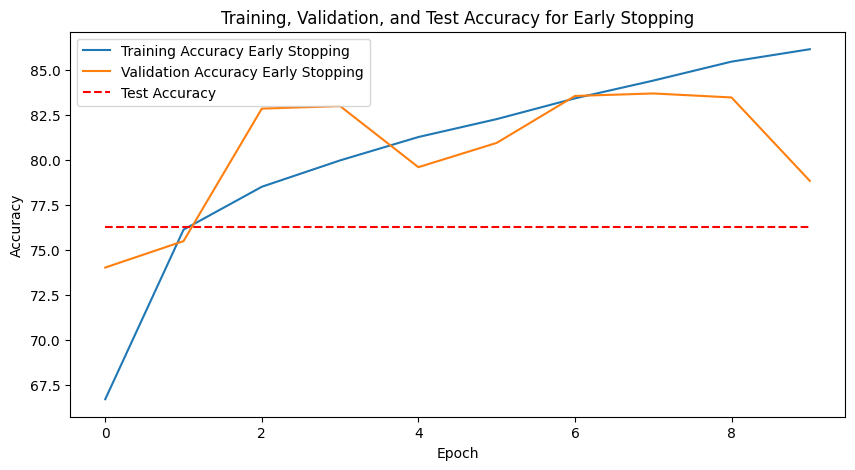

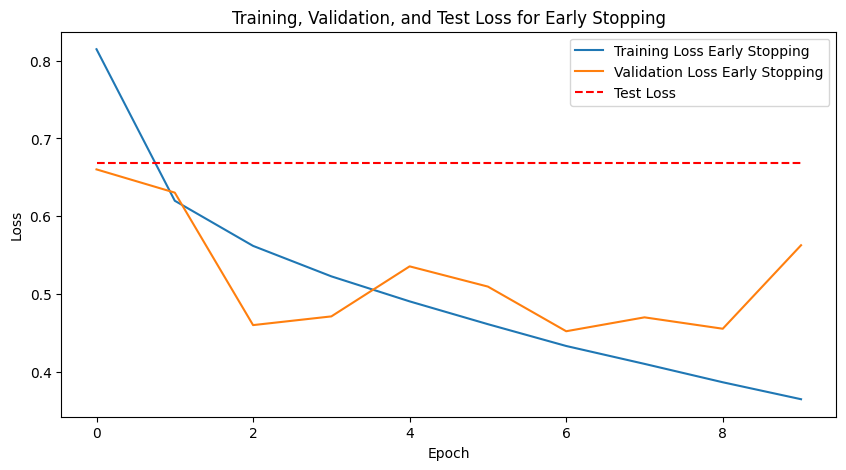

In [22]:
#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_early_stopping, label='Training Accuracy Early Stopping')
plt.plot(validation_accuracy_early_stopping, label='Validation Accuracy Early Stopping')
plt.plot(test_accuracies_plot_early_stopping, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy for Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss_early_stopping, label='Training Loss Early Stopping')
plt.plot(validation_loss_early_stopping, label='Validation Loss Early Stopping')
plt.plot(test_loss_plot_early_stopping, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss for Early Stopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Hyperparamter Change #2

In [23]:
model_optimizer = CNNmodel_octmnist().to(device)
loss_function_optimizer = nn.CrossEntropyLoss()
optimizer_optimizer = torch.optim.SGD(model_optimizer.parameters(), lr=0.01, momentum=0.9) 

train_loss_optimizer = []
validation_loss_optimizer = []
train_accuracy_optimizer = []
validation_accuracy_optimizer = []

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

start_time_optimizer = time.time()

epochs = 15

# save_path = "best_weights.p"
best_validation_loss = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

for epoch in range(epochs):
  model_optimizer.train()
  loop_train_loss = 0
  correct_train_length = 0
  total_train = 0

  for inputs, labels in train_loader:
      
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer_optimizer.zero_grad()

    outputs = model_optimizer(inputs)
        
    loss = loss_function_optimizer(outputs, labels)
    loss.backward()
    optimizer_optimizer.step()

    _, predicted = torch.max(outputs, 1)
    total_train += labels.size(0)
    correct_train_length += (predicted == labels).sum().item()

    loop_train_loss += loss.item()

  #training accuracy and loss
  train_accuracy_value_optimizer = 100 * correct_train_length / total_train
  train_loss_optimizer.append(loop_train_loss / len(train_loader))
  train_accuracy_optimizer.append(train_accuracy_value_optimizer)

  #Validation
  model_optimizer.eval()
  loop_val_loss = 0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model_optimizer(val_inputs)

        val_labels = val_labels.view(-1)
        val_loss = loss_function_optimizer(val_outputs, val_labels)

        # Track validation accuracy
        _, predicted = torch.max(val_outputs, 1)
        
        total_val += val_labels.size(0)
        correct_val += (predicted == val_labels).sum().item()
    
        loop_val_loss += val_loss.item()

  #validation accuracy and loss
  val_accuracy_optimizer = 100 * correct_val / total_val
  validation_loss_optimizer.append(loop_val_loss / len(val_loader))
  validation_accuracy_optimizer.append(val_accuracy_optimizer)

  print(f"Epoch [{epoch+1}/{epochs}], "
    f"Train Loss: {train_loss_optimizer[-1]:.4f}, Train Accuracy: {train_accuracy_optimizer[-1]:.2f}%, "
    f"Val Loss: {validation_loss_optimizer[-1]:.4f}, Val Accuracy: {validation_accuracy_optimizer[-1]:.2f}%")


  # if loop_val_loss < best_validation_loss:
  #   best_validation_loss = loop_val_loss
  #   best_epoch = epoch + 1
  #   best_model_weight = model.state_dict()
  #   # torch.save(model.state_dict(), 'best_model.pth')  #Save the model weights

# if best_model_weight is not None:
#     torch.save(best_model_weight, save_path)
#     print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time_optimizer = time.time()
training_time_optimizer = end_time_optimizer - start_time_optimizer  #total training time
print(f"Total Training Time for SGD Optimizer Loss Function Model: {training_time_optimizer:.2f} seconds")

Epoch [1/15], Train Loss: 0.8216, Train Accuracy: 65.25%, Val Loss: 0.4838, Val Accuracy: 81.93%
Epoch [2/15], Train Loss: 0.5103, Train Accuracy: 80.56%, Val Loss: 0.4250, Val Accuracy: 83.85%
Epoch [3/15], Train Loss: 0.4189, Train Accuracy: 84.15%, Val Loss: 0.4535, Val Accuracy: 82.82%
Epoch [4/15], Train Loss: 0.3531, Train Accuracy: 86.78%, Val Loss: 0.3920, Val Accuracy: 85.86%
Epoch [5/15], Train Loss: 0.3006, Train Accuracy: 88.72%, Val Loss: 0.3772, Val Accuracy: 87.22%
Epoch [6/15], Train Loss: 0.2565, Train Accuracy: 90.43%, Val Loss: 0.4300, Val Accuracy: 85.90%
Epoch [7/15], Train Loss: 0.2236, Train Accuracy: 91.68%, Val Loss: 0.4885, Val Accuracy: 85.20%
Epoch [8/15], Train Loss: 0.1958, Train Accuracy: 92.77%, Val Loss: 0.5080, Val Accuracy: 84.24%
Epoch [9/15], Train Loss: 0.1716, Train Accuracy: 93.68%, Val Loss: 0.4969, Val Accuracy: 85.86%
Epoch [10/15], Train Loss: 0.1533, Train Accuracy: 94.43%, Val Loss: 0.5187, Val Accuracy: 85.34%
Epoch [11/15], Train Loss: 0.

In [24]:
# Test phase
model_optimizer.eval()
correct_test_length = 0
total_test = 0
y_true_optimizer = []
y_pred_optimizer = []

# test_loss = []
test_accuracy_optimizer =[]
test_total_loss = 0.0
test_epoch_accuracy = 0
predicted_list_optimizer = []


with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
      
    outputs = model_optimizer(inputs)

    labels = labels.view(-1)
    test_total_loss += loss_function_optimizer(outputs, labels).item()
      
    _, predicted = torch.max(outputs, 1)
    predicted_test_probs = torch.softmax(outputs, dim=1)
      
    total_test += labels.size(0)
    correct_test_length += (predicted == labels).sum().item()

    y_true_optimizer.extend(labels.cpu().numpy())
    y_pred_optimizer.extend(predicted.cpu().numpy())
    predicted_list_optimizer.extend(predicted_test_probs.cpu().numpy())


y_pred_optimizer = np.array(y_pred_optimizer)
y_true_optimizer = np.array(y_true_optimizer)
predicted_list_optimizer = np.array(predicted_list_optimizer)


print(f"Predicted: {y_pred_optimizer[:10]}")
print(f"Actual Labels: {y_true_optimizer[:10]}")

test_accuracy_optimizer = 100 * (correct_test_length / total_test)
print(f"Test Accuracy SGD Optimizer: {test_accuracy_optimizer:.2f}%")

#Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true_optimizer, y_pred_optimizer, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

test_loss = test_total_loss /len(test_loader)

test_accuracies_plot_optimizer = [test_accuracy_optimizer] * epochs
test_loss_plot_optimizer = [test_loss] * epochs


Predicted: [3 0 3 3 0 3 1 0 0 2]
Actual Labels: [3 2 3 3 0 2 1 0 0 3]
Test Accuracy SGD Optimizer: 75.90%
Precision: 0.7757, Recall: 0.7590, F1: 0.7408


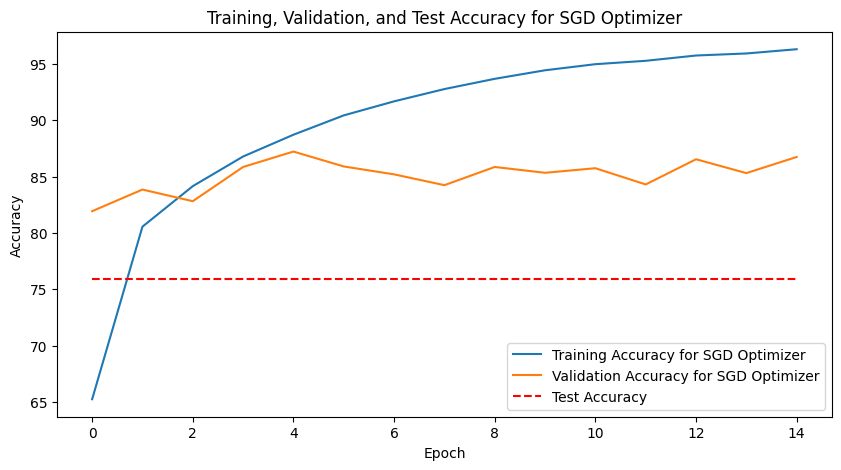

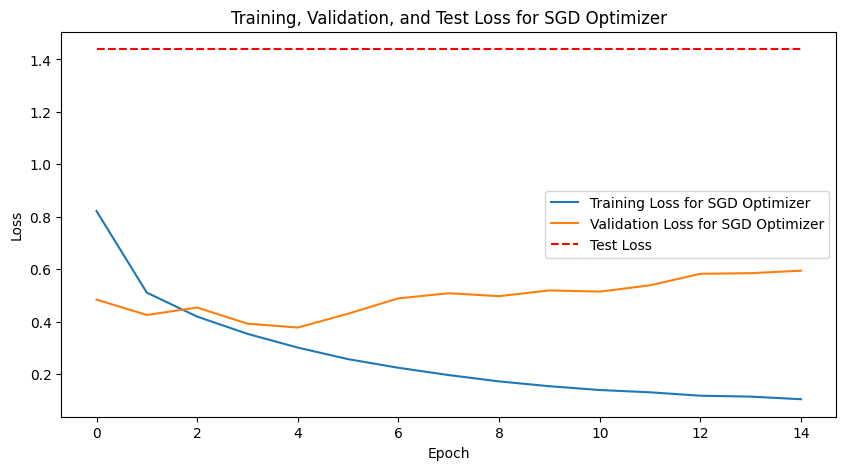

In [25]:
#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_optimizer, label='Training Accuracy for SGD Optimizer')
plt.plot(validation_accuracy_optimizer, label='Validation Accuracy for SGD Optimizer')
plt.plot(test_accuracies_plot_optimizer, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy for SGD Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss_optimizer, label='Training Loss for SGD Optimizer')
plt.plot(validation_loss_optimizer, label='Validation Loss for SGD Optimizer')
plt.plot(test_loss_plot_optimizer, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss for SGD Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Hyperparamter Change #3

In [26]:
model_lr_scheduler = CNNmodel_octmnist().to(device)
loss_function_lr_scheduler = nn.CrossEntropyLoss()
optimizer_lr_scheduler = optim.Adam(model_lr_scheduler.parameters(), lr=0.001, weight_decay=0.00001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_loss_lr_scheduler = []
validation_loss_lr_scheduler = []
train_accuracy_lr_scheduler = []
validation_accuracy_lr_scheduler = []

#learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lr_scheduler, 'min', factor=0.1, patience=3)

start_time_lr_scheduler = time.time()

epochs = 10

# save_path = "best_weights.p"
best_validation_loss = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

for epoch in range(epochs):
  model_lr_scheduler.train()
  loop_train_loss = 0
  correct_train_length = 0
  total_train = 0

  for inputs, labels in train_loader:
      
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer_lr_scheduler.zero_grad()

    outputs = model_lr_scheduler(inputs)
        
    loss = loss_function_lr_scheduler(outputs, labels)
    loss.backward()
    optimizer_lr_scheduler.step()

    _, predicted = torch.max(outputs, 1)
    total_train += labels.size(0)
    correct_train_length += (predicted == labels).sum().item()

    loop_train_loss += loss.item()

  #training accuracy and loss
  train_accuracy_value_lr_scheduler = 100 * correct_train_length / total_train
  train_loss_lr_scheduler.append(loop_train_loss / len(train_loader))
  train_accuracy_lr_scheduler.append(train_accuracy_value_lr_scheduler)

  #Validation
  model_lr_scheduler.eval()
  loop_val_loss = 0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model_lr_scheduler(val_inputs)

        val_labels = val_labels.view(-1)
        val_loss = loss_function_lr_scheduler(val_outputs, val_labels)

        _, predicted = torch.max(val_outputs, 1)
        
        total_val += val_labels.size(0)
        correct_val += (predicted == val_labels).sum().item()
    
        loop_val_loss += val_loss.item()

  #validation accuracy and loss
  val_accuracy_lr_scheduler = 100 * correct_val / total_val
  validation_loss_lr_scheduler.append(loop_val_loss / len(val_loader))
  validation_accuracy_lr_scheduler.append(val_accuracy_lr_scheduler)

  print(f"Epoch [{epoch+1}/{epochs}], "
    f"Train Loss: {train_loss_lr_scheduler[-1]:.4f}, Train Accuracy: {train_accuracy_lr_scheduler[-1]:.2f}%, "
    f"Val Loss: {validation_loss_lr_scheduler[-1]:.4f}, Val Accuracy: {validation_accuracy_lr_scheduler[-1]:.2f}%")


  #update the value of scheduler
  scheduler.step(loop_val_loss)

  # if loop_val_loss < best_validation_loss:
  #   best_validation_loss = loop_val_loss
  #   best_epoch = epoch + 1
  #   best_model_weight = model.state_dict()
  #   # torch.save(model.state_dict(), 'best_model.pth')  #Save the model weights

# if best_model_weight is not None:
#     torch.save(best_model_weight, save_path)
#     print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time_lr_scheduler = time.time()
training_time_lr_scheduler = end_time_lr_scheduler - start_time_lr_scheduler  #total training time
print(f"Total Training Time for Learning Rate Scheduler Model: {training_time_lr_scheduler:.2f} seconds")

Epoch [1/10], Train Loss: 0.7014, Train Accuracy: 72.07%, Val Loss: 0.5249, Val Accuracy: 79.98%
Epoch [2/10], Train Loss: 0.5101, Train Accuracy: 80.64%, Val Loss: 0.4293, Val Accuracy: 84.90%
Epoch [3/10], Train Loss: 0.4446, Train Accuracy: 83.21%, Val Loss: 0.3874, Val Accuracy: 85.64%
Epoch [4/10], Train Loss: 0.3979, Train Accuracy: 84.97%, Val Loss: 0.4606, Val Accuracy: 82.77%
Epoch [5/10], Train Loss: 0.3628, Train Accuracy: 86.34%, Val Loss: 0.3909, Val Accuracy: 86.27%
Epoch [6/10], Train Loss: 0.3304, Train Accuracy: 87.51%, Val Loss: 0.3973, Val Accuracy: 86.98%
Epoch [7/10], Train Loss: 0.3023, Train Accuracy: 88.69%, Val Loss: 0.4121, Val Accuracy: 85.64%
Epoch [8/10], Train Loss: 0.2106, Train Accuracy: 92.27%, Val Loss: 0.4286, Val Accuracy: 85.98%
Epoch [9/10], Train Loss: 0.1880, Train Accuracy: 93.13%, Val Loss: 0.4363, Val Accuracy: 85.64%
Epoch [10/10], Train Loss: 0.1760, Train Accuracy: 93.63%, Val Loss: 0.4298, Val Accuracy: 86.50%
Total Training Time for Learn

In [27]:
# Test phase
model_lr_scheduler.eval()
correct_test_length = 0
total_test = 0
y_true_lr_scheduler = []
y_pred_lr_scheduler = []

test_accuracy_lr_scheduler =[]
test_total_loss = 0.0
test_epoch_accuracy = 0
predicted_list_lr_scheduler = []


with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
      
    outputs = model_lr_scheduler(inputs)

    labels = labels.view(-1)
    test_total_loss += loss_function_lr_scheduler(outputs, labels).item()
      
    _, predicted = torch.max(outputs, 1)
    predicted_test_probs = torch.softmax(outputs, dim=1)
      
    total_test += labels.size(0)
    correct_test_length += (predicted == labels).sum().item()

    y_true_lr_scheduler.extend(labels.cpu().numpy())
    y_pred_lr_scheduler.extend(predicted.cpu().numpy())
    predicted_list_lr_scheduler.extend(predicted_test_probs.cpu().numpy())


y_pred_lr_scheduler = np.array(y_pred_lr_scheduler)
y_true_lr_scheduler = np.array(y_true_lr_scheduler)
predicted_list_lr_scheduler = np.array(predicted_list_lr_scheduler)


print(f"Predicted: {y_pred_lr_scheduler[:10]}")
print(f"Actual Labels: {y_true_lr_scheduler[:10]}")

test_accuracy_lr_scheduler = 100 * (correct_test_length / total_test)
print(f"Test Accuracy Learning Rate Scheduler: {test_accuracy_lr_scheduler:.2f}%")

#Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true_lr_scheduler, y_pred_lr_scheduler, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

test_loss = test_total_loss /len(test_loader)

test_accuracies_plot_lr_scheduler = [test_accuracy_lr_scheduler] * epochs
test_loss_plot_lr_scheduler = [test_loss] * epochs


Predicted: [3 3 3 3 0 2 1 0 0 3]
Actual Labels: [3 2 3 3 0 2 1 0 0 3]
Test Accuracy Learning Rate Scheduler: 75.00%
Precision: 0.7822, Recall: 0.7500, F1: 0.7307


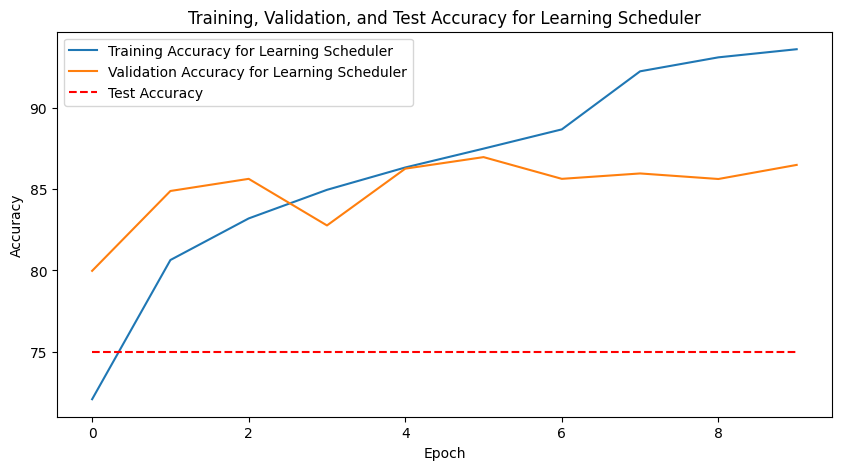

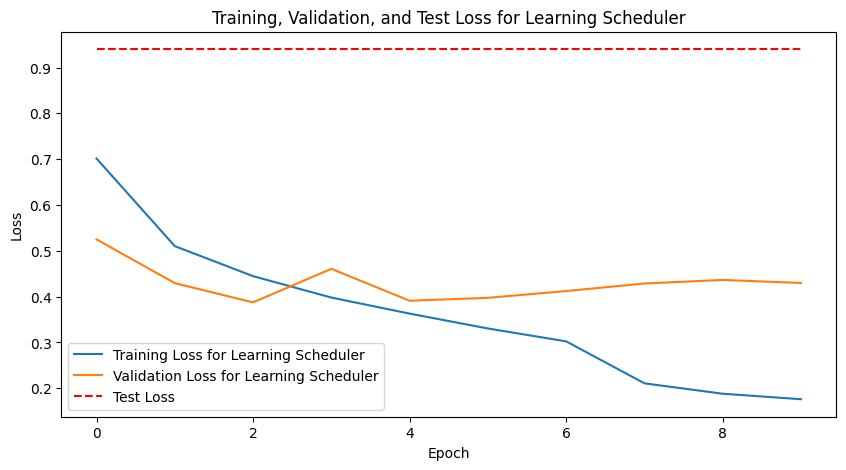

In [28]:
#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_lr_scheduler, label='Training Accuracy for Learning Scheduler')
plt.plot(validation_accuracy_lr_scheduler, label='Validation Accuracy for Learning Scheduler')
plt.plot(test_accuracies_plot_lr_scheduler, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy for Learning Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss_lr_scheduler, label='Training Loss for Learning Scheduler')
plt.plot(validation_loss_lr_scheduler, label='Validation Loss for Learning Scheduler')
plt.plot(test_loss_plot_lr_scheduler, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss for Learning Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



Hyperparameter Change #4

In [29]:
# Adding batch normalization
class CNNmodel_octmnist(nn.Module):
  def __init__(self):
    super(CNNmodel_octmnist, self).__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(256 * 3 * 3, 512)  # 3 conv layers and 2 max-pool
    self.fc2 = nn.Linear(512, 4)  # 4 classes

    self.dropout = nn.Dropout(0.5)

  def forward(self, x):

    x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
    x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
    x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))

    x = x.view(-1, 256 * 3 * 3)

    x = nn.ReLU()(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [30]:
model_batch_norm = CNNmodel_octmnist().to(device)
loss_function_batch_norm = nn.CrossEntropyLoss()
optimizer_batch_norm = optim.Adam(model_batch_norm.parameters(), lr=0.001, weight_decay=0.00001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_loss_batch_norm = []
validation_loss_batch_norm = []
train_accuracy_batch_norm = []
validation_accuracy_batch_norm = []

start_time_batch_norm = time.time()

epochs = 10

# save_path = "best_weights.p"
best_validation_loss = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

for epoch in range(epochs):
  model_batch_norm.train()
  loop_train_loss = 0
  correct_train_length = 0
  total_train = 0

  for inputs, labels in train_loader:
      
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer_batch_norm.zero_grad()

    outputs = model_batch_norm(inputs)
    
    # if labels.ndimension() > 1:  # In case labels are one-hot encoded
    #     labels = torch.argmax(labels, dim=1)
        
    loss = loss_function_batch_norm(outputs, labels)
    loss.backward()
    optimizer_batch_norm.step()

    _, predicted = torch.max(outputs, 1)
    total_train += labels.size(0)
    correct_train_length += (predicted == labels).sum().item()

    loop_train_loss += loss.item()

  #training accuracy and loss
  train_accuracy_value_batch_norm = 100 * correct_train_length / total_train
  train_loss_batch_norm.append(loop_train_loss / len(train_loader))
  train_accuracy_batch_norm.append(train_accuracy_value_batch_norm)

  #Validation
  model_batch_norm.eval()
  loop_val_loss = 0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model_batch_norm(val_inputs)

        # if val_labels.ndimension() > 1:  # In case labels are one-hot encoded
        #     val_labels = torch.argmax(val_labels, dim=1)

        val_labels = val_labels.view(-1)
        val_loss = loss_function_batch_norm(val_outputs, val_labels)

        _, predicted = torch.max(val_outputs, 1)
        
        total_val += val_labels.size(0)
        correct_val += (predicted == val_labels).sum().item()
    
        loop_val_loss += val_loss.item()

  #validation accuracy and loss
  val_accuracy_batch_norm = 100 * correct_val / total_val
  validation_loss_batch_norm.append(loop_val_loss / len(val_loader))
  validation_accuracy_batch_norm.append(val_accuracy_batch_norm)

  print(f"Epoch [{epoch+1}/{epochs}], "
    f"Train Loss: {train_loss_batch_norm[-1]:.4f}, Train Accuracy: {train_accuracy_batch_norm[-1]:.2f}%, "
    f"Val Loss: {validation_loss_batch_norm[-1]:.4f}, Val Accuracy: {validation_accuracy_batch_norm[-1]:.2f}%")


  # if loop_val_loss < best_validation_loss:
  #   best_validation_loss = loop_val_loss
  #   best_epoch = epoch + 1
  #   best_model_weight = model.state_dict()
  #   # torch.save(model.state_dict(), 'best_model.pth')  #Save the model weights

# if best_model_weight is not None:
#     torch.save(best_model_weight, save_path)
#     print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time_batch_norm = time.time()
training_time_batch_norm = end_time_batch_norm - start_time_batch_norm  #total training time
print(f"Total Training Time for Batch Normalization Model: {training_time_batch_norm:.2f} seconds")

Epoch [1/10], Train Loss: 0.6546, Train Accuracy: 74.70%, Val Loss: 0.5339, Val Accuracy: 81.31%
Epoch [2/10], Train Loss: 0.4583, Train Accuracy: 82.97%, Val Loss: 0.4225, Val Accuracy: 84.38%
Epoch [3/10], Train Loss: 0.3746, Train Accuracy: 86.23%, Val Loss: 0.3750, Val Accuracy: 86.71%
Epoch [4/10], Train Loss: 0.3048, Train Accuracy: 88.85%, Val Loss: 0.3719, Val Accuracy: 87.62%
Epoch [5/10], Train Loss: 0.2490, Train Accuracy: 90.85%, Val Loss: 0.4565, Val Accuracy: 85.54%
Epoch [6/10], Train Loss: 0.2059, Train Accuracy: 92.48%, Val Loss: 0.3905, Val Accuracy: 87.68%
Epoch [7/10], Train Loss: 0.1743, Train Accuracy: 93.71%, Val Loss: 0.4887, Val Accuracy: 85.53%
Epoch [8/10], Train Loss: 0.1487, Train Accuracy: 94.61%, Val Loss: 0.4753, Val Accuracy: 86.62%
Epoch [9/10], Train Loss: 0.1284, Train Accuracy: 95.39%, Val Loss: 0.6486, Val Accuracy: 86.03%
Epoch [10/10], Train Loss: 0.1135, Train Accuracy: 95.91%, Val Loss: 0.5037, Val Accuracy: 88.41%
Total Training Time for Batch

In [31]:
# Test phase
model_batch_norm.eval()
correct_test_length = 0
total_test = 0
y_true_batch_norm = []
y_pred_batch_norm = []

test_accuracy_batch_norm =[]
test_total_loss = 0.0
test_epoch_accuracy = 0
predicted_list_batch_norm = []


with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
      
    outputs = model_batch_norm(inputs)

    labels = labels.view(-1)
    test_total_loss += loss_function_batch_norm(outputs, labels).item()
      
    _, predicted = torch.max(outputs, 1)
    predicted_test_probs = torch.softmax(outputs, dim=1)
      
    total_test += labels.size(0)
    correct_test_length += (predicted == labels).sum().item()

    y_true_batch_norm.extend(labels.cpu().numpy())
    y_pred_batch_norm.extend(predicted.cpu().numpy())
    predicted_list_batch_norm.extend(predicted_test_probs.cpu().numpy())


y_pred_batch_norm = np.array(y_pred_batch_norm)
y_true_batch_norm = np.array(y_true_batch_norm)
predicted_list_batch_norm = np.array(predicted_list_batch_norm)


print(f"Predicted: {y_pred_batch_norm[:10]}")
print(f"Actual Labels: {y_true_batch_norm[:10]}")

test_accuracy_batch_norm = 100 * (correct_test_length / total_test)
print(f"Test Accuracy Batch Normalization: {test_accuracy_batch_norm:.2f}%")

#Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true_batch_norm, y_pred_batch_norm, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

test_loss = test_total_loss /len(test_loader)

test_accuracies_plot_batch_norm = [test_accuracy_batch_norm] * epochs
test_loss_plot_batch_norm = [test_loss] * epochs


Predicted: [3 2 3 3 0 3 1 0 0 3]
Actual Labels: [3 2 3 3 0 2 1 0 0 3]
Test Accuracy Batch Normalization: 74.80%
Precision: 0.7905, Recall: 0.7480, F1: 0.7122


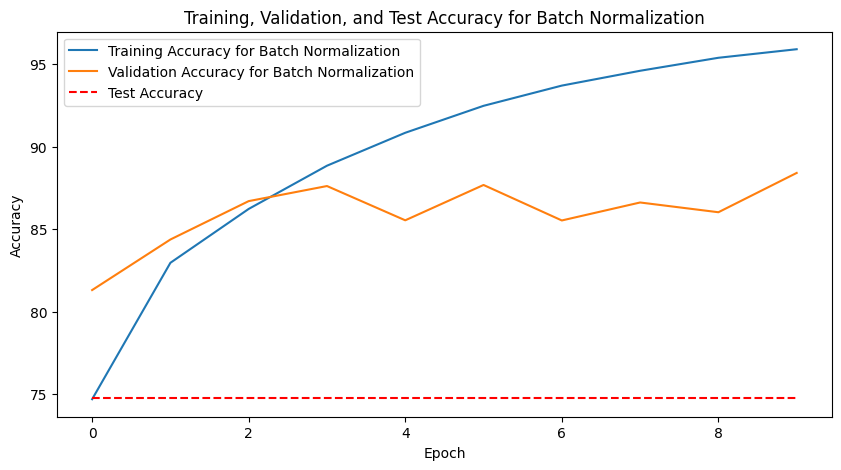

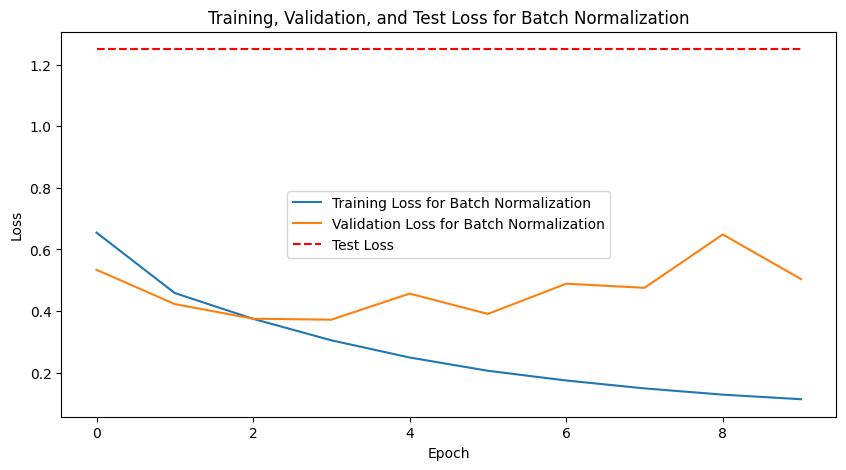

In [32]:
#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_batch_norm, label='Training Accuracy for Batch Normalization')
plt.plot(validation_accuracy_batch_norm, label='Validation Accuracy for Batch Normalization')
plt.plot(test_accuracies_plot_batch_norm, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy for Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss_batch_norm, label='Training Loss for Batch Normalization')
plt.plot(validation_loss_batch_norm, label='Validation Loss for Batch Normalization')
plt.plot(test_loss_plot_batch_norm, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss for Batch Normalization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



#  Best Improved Model : In this improved models the best one with good accuracy is the one using batch normalization.

In [39]:
import pickle

#the best model and weights
# pickle.dump(model_early_stopping, open( "a0_part3_best_model_ra65.p", "wb" ) )
torch.save(model_early_stopping.state_dict(), "a0_part3_best_model_ra65.pt")

Best model graphs

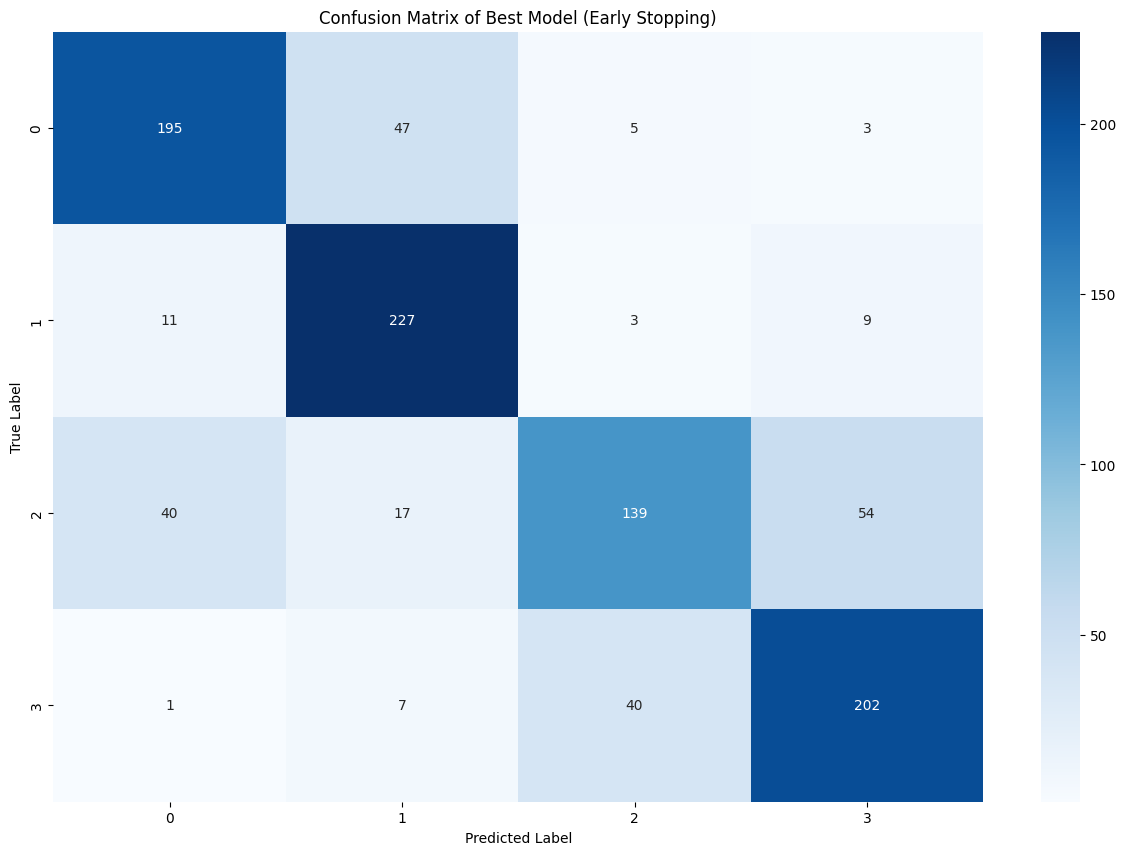

In [41]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_true_early_stopping, y_pred_early_stopping)
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Best Model (Early Stopping)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

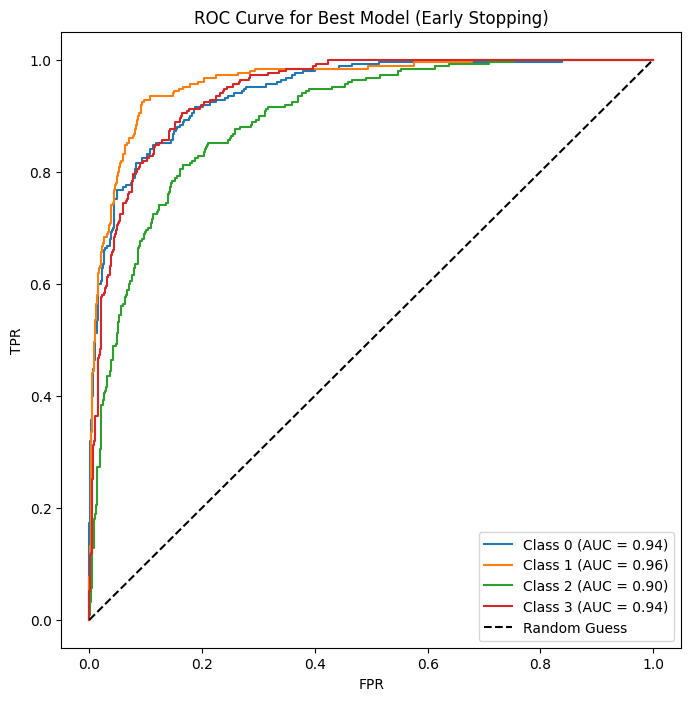

In [42]:
#plotting the ROC curve
plt.figure(figsize=(8,8))
test_dataset_labels_binarized = label_binarize(y_true_early_stopping, classes=np.arange(4))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_dataset_labels_binarized[:, i], predicted_list_early_stopping[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i}').plot(ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Best Model (Early Stopping)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


References:
- https://www.kaggle.com/code/albertostefani/binary-classification-of-octmnist-dataset
- https://medium.com/@fatimazahra.belharar/enhancing-classification-accuracy-for-imbalanced-image-data-using-smote-41737783a720
- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
- https://www.geeksforgeeks.org/counters-in-python-set-1/
- https://discuss.pytorch.org/t/loss-backward-runtime-error/89872
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
- https://medium.com/@ramamurthi96/a-simple-neural-network-model-for-mnist-using-pytorch-4b8b148ecbdc
- https://colab.research.google.com/github/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb#scrollTo=9XaA4ovp6qAU
- https://github.com/MedMNIST/MedMNIST
- Used code as reference from CSE CSE574: ra65_ganeshdi_assignment_2: CNN's and NN models and graphs
